In [57]:
import os
import re
import pickle
import numpy as np
from matplotlib import  pyplot as plt
plt.style.use('seaborn-v0_8')

In [99]:
def get_meta_data(file_name):
    element = re.search(r'^.*?(?=-)', file_name).group(0)
    features = re.search(r'(?<=-F-).*(?=-T-)', file_name).group(0).split('-')
    target = re.search(r'(?<=-T-).*(?=.pickle)', file_name).group(0)
    return element, features, target

def get_label(meta_data, name):
    label_dict = {'element':0, "feature":1, 'target':2}
    return [meta_data[i][label_dict[name]] for i in range(len(meta_data))]

In [ ]:
def load_data(data_dir, get_meta_data):
    file_names = os.listdir(data_dir)
    file_path = [os.path.join(data_dir, file) for file in file_names]

    meta_data = []
    for i in range(len(file_names)):
        meta_data.append(get_meta_data(file_names[i]))

    Data = []
    for i in range(len(file_path)):
        with open(file_path[i], 'rb') as f:
            data = pickle.load(f)
            Data.append(data)

    return Data, meta_data

In [ ]:
Data[0][0]

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.82910369, 0.88375993, 0.90346419, 0.89027833, 0.92291521]])

In [300]:
Data = load_data('results', get_meta_data)
# Data = np.array(Data)

# means = np.zeros(len(Data))
# stds = np.zeros(len(Data))
# for i in range(len(Data)):
#     data = Data[i][1,:]
#     means[i] = np.mean(data)
#     stds[i] = np.std(data)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [138]:
def results_filter(meta_data, condition, *data):
    mask = np.array(list(map(lambda x: np.all([condition[i](x) for i in range(len(condition))]), meta_data)), dtype=bool)
    inds = np.arange(len(data[0]))[mask]
    new_data = [[data[i][inds[j]] for j in range(len(inds))] for i in range(len(data))]
    return new_data
    
def direct_select_condition(names, entry_name):
    label_dict = {'element':0, "feature":1, 'target':2}
    return lambda x: np.all([names[i] in x[label_dict[entry_name]] for i in range(len(names))])

one_feature_condition = lambda x: len(x[1]) == 1
cs_condition = lambda x: x[2] == 'cs'
cn_condition = lambda x: x[2] == 'cn'

In [139]:
nx_condition = direct_select_condition(['n_pdf', 'x_pdf'], 'feature')
data = results_filter(meta_data, [nx_condition], meta_data)
data

[[('Ti', ['n_pdf', 'x_pdf'], 'cn'),
  ('Ti', ['n_pdf', 'x_pdf'], 'cs'),
  ('Ti', ['x_pdf', 'n_pdf'], 'cs'),
  ('Ti', ['x_pdf', 'n_pdf'], 'cn')]]

In [ ]:
class Painter():
    def __init__(self, labels):
        self.labels = labels
        self.metrics = []
        self.errors = []
        
    def plot(self, metrics, leg, error=None):
        self.metrics.append(metrics)
        self.errors.append(error)
        n_class = len(self.metrics)

        if plt.gcf():
            plt.close()
        
        fig, ax = plt.subplots()
        width = 1/(n_class+0.5)

        x0 = np.arange(len(self.metrics[0]))
        ax.set_xticks(x0, labels, rotation=45)
    
        for i in range(n_class):
            x = x0 + width*i
            if not self.errors[i]:
                ax.bar(x, self.metrics[i], width=width, label=leg)
            else:
                ax.bar(x, self.metrics[i], yerr=self.errors[i],width=width, label=leg)
                
            for j in range(len(self.metrics[i])):
                ax.text(x[j], self.metrics[i][j]*1.01, "{:.2f}".format(self.metrics[i][j]), horizontalalignment='center')
            
        plt.legend()


(0.8, 1.0)

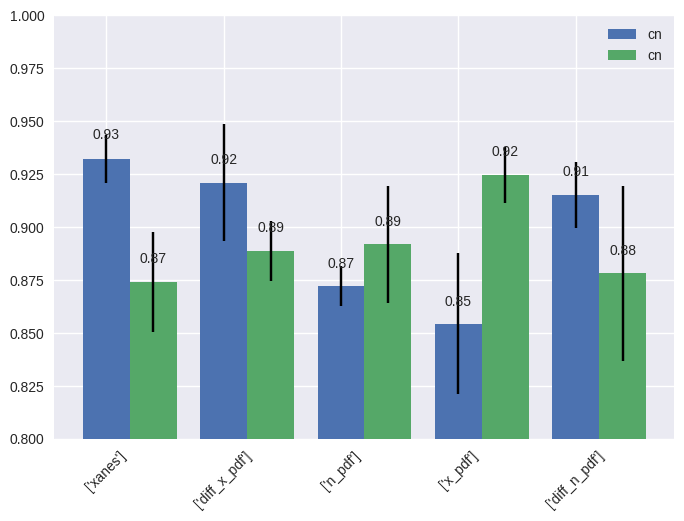

In [267]:
f_cs_mean, f_cs_std,f_meta_data = results_filter(meta_data, [one_feature_condition, cs_condition], means, stds, meta_data)
f_cn_mean, f_cn_std= results_filter(meta_data, [one_feature_condition, cn_condition], means, stds)
labels = get_label(f_meta_data, 'feature')
painter = Painter(labels)
painter.plot(f_cs_mean, leg='cs', error=f_cs_std)
painter.plot(f_cn_mean, leg='cn', error=f_cn_std)
plt.ylim([0.8,1])

In [184]:
feature_options = ['xanes', 'x_pdf', 'n_pdf', 'diff_x_pdf', 'diff_n_pdf']
features_of_interest = [[feature_options[i], feature_options[j]] for j in range(5) for i in range(5) if j<i]

(0.8, 1.0)

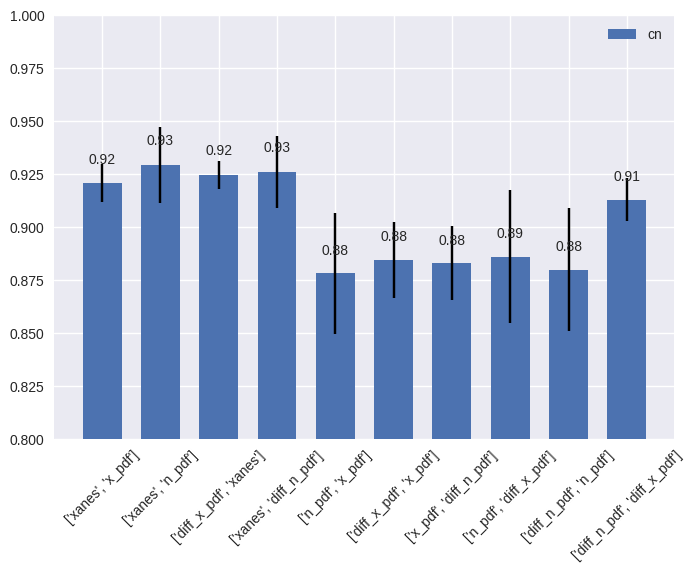

In [270]:
metrics = []
f_meta_data = []
f_stds = []

for i in range(len(features_of_interest)):
    condition = direct_select_condition(features_of_interest[i], 'feature')
    data = results_filter(meta_data, [condition, cn_condition], means, stds, meta_data)
    metrics.append(data[0][0])
    f_stds.append(data[1][0])
    f_meta_data.append(data[-1][0])
    
labels = get_label(f_meta_data, 'feature')
painter = Painter(labels)
painter.plot(metrics, 'cn', error=f_stds)
plt.ylim([0.8,1])

(0.8, 1.0)

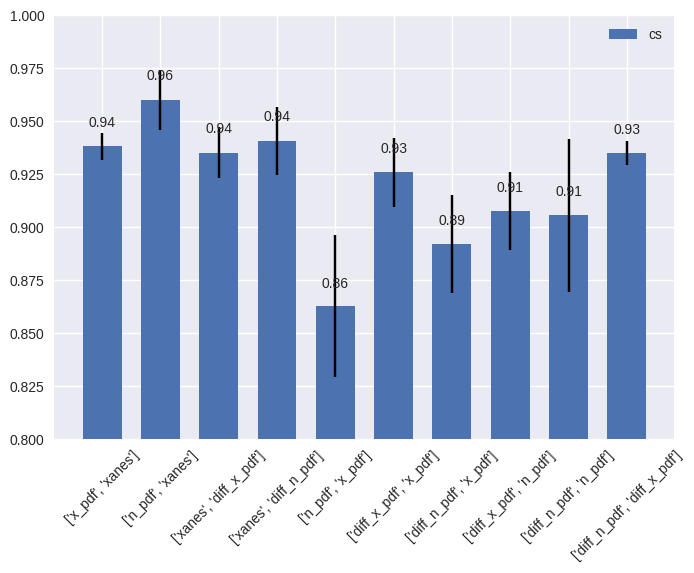

In [276]:
metrics = []
f_meta_data = []
f_stds = []

for i in range(len(features_of_interest)):
    condition = direct_select_condition(features_of_interest[i], 'feature')
    data = results_filter(meta_data, [condition, cs_condition], means, stds,meta_data)
    metrics.append(data[0][0])
    f_stds.append(data[1][0])
    f_meta_data.append(data[-1][0])    
    
    
labels = get_label(f_meta_data, 'feature')
painter = Painter(labels)
painter.plot(metrics, 'cs', error=f_stds)
plt.ylim([0.8,1])

# BETTER API

In [402]:
def load_data(data_dir, get_meta_data):
    file_names = os.listdir(data_dir)
    file_path = [os.path.join(data_dir, file) for file in file_names]

    Data = []
    for i in range(len(file_names)):
        element, features, target = get_meta_data(file_names[i])
        data = {'element':element, 'features':features, 'target':target}
        with open(file_path[i], 'rb') as f:
            tmp = pickle.load(f)
            tmp = np.array(tmp)
            data['train_score'] = tmp[0]
            data['test_score'] = tmp[1]
        Data.append(data)
    return Data

Data = load_data('results', get_meta_data)

In [ ]:
def filter_data(data, conditions):
    mask = np.array(list(map(lambda x: np.all([conditions[i](x) for i in range(len(conditions))]), data)))
    inds = np.arange(len(data))[mask]
    return [data[i] for i in inds]

def generate_condition(key, value, mode='str'):
    if mode == 'str':
        return lambda x: value in x[key]
    else:
        return lambda x: len(x[key])==value

def combine_data(data, key, method=None):
    if not method:
        out = [data[i][key] for i in range(len(data))]
    else:
        out = [method(data[i][key]) for i in range(len(data))]

    return out
    


one_feature_condition = lambda x: len(x['features'])==1
cs_condition = lambda x: x['target'] == 'cs'
cn_condition = lambda x: x['target'] == 'cn'


In [405]:
class Painter():
    def __init__(self):
        self.metrics = []
        self.plot_params = []
        
    def plot(self, xtick_labels, metrics, plot_param):
        
        self.metrics.append(metrics)
        self.plot_params.append(plot_param)

        n_class = len(self.metrics)

        if plt.gcf():
            plt.close()
        
        fig, ax = plt.subplots()
        width = 1/(n_class+0.5)
        x0 = np.arange(len(self.metrics[0]))
        ax.set_xticks(x0, xtick_labels, rotation=45)
    
        for i in range(n_class):
            x = x0 + width*i
            ax.bar(x, self.metrics[i], width=width, **self.plot_params[i])
                
            for j in range(len(self.metrics[i])):
                ax.text(x[j], self.metrics[i][j]*1.01, "{:.2f}".format(self.metrics[i][j]), horizontalalignment='center')
            
        plt.legend()

In [406]:
def sort_by_match(labels, values, matched_labels):
    return [values[i] for i in range(len(labels)) for j in range(len(matched_labels)) if labels[i] == matched_labels[j] ]

(0.8, 1.0)

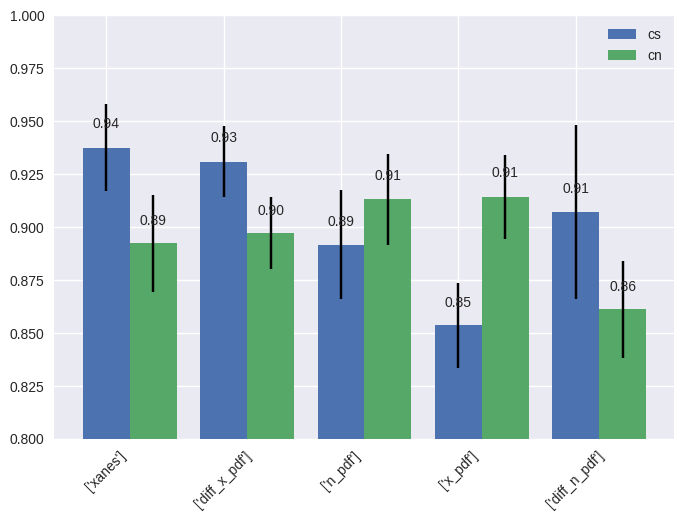

In [419]:
var_condition = [cs_condition, cn_condition]
var_leg = ['cs', 'cn']
painter = Painter()
match_labels = []
for i in range(len(var_leg)):
    data = data_filter(Data, [one_feature_condition, var_condition[i], Ti_condition])
    if len(match_labels) == 0:
        match_labels = combine_data(data, 'features')
    else: 
        labels = combine_data(data, 'features')
        data = sort_by_match(labels, data, match_labels)
        
    mean = combine_data(data, 'test_score', np.mean)
    std = combine_data(data, 'test_score', np.std)
    painter.plot(match_labels, mean, plot_param={'yerr':std, 'label':var_leg[i]})
    
    
plt.ylim([0.8,1])

In [389]:
feature_options = ['xanes', 'x_pdf', 'n_pdf', 'diff_x_pdf', 'diff_n_pdf']
features_of_interest = [[feature_options[i], feature_options[j]] for j in range(5) for i in range(5) if j<i]
feature_conditions = [[generate_condition('features', features_of_interest[i][0]), \
    generate_condition('features', features_of_interest[i][1])] for i in range(len(features_of_interest))]


# Ti

Text(0.5, 1.0, 'Ti')

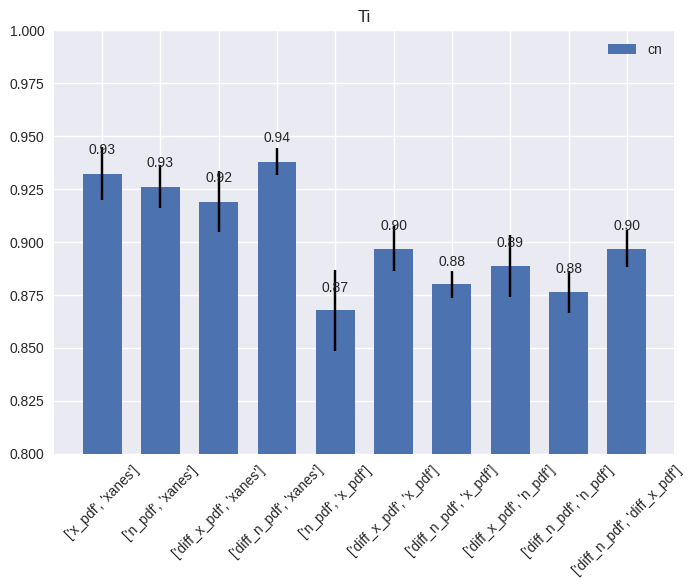

In [430]:
ele_condition = lambda x: x['element'] == 'Ti'
target_condition = cn_condition
leg = 'cn'
xtick_labels = features_of_interest
means = []
stds = []
painter = Painter()

for i in range(len(feature_conditions)):
    data = data_filter(Data, [*feature_conditions[i], cn_condition, ele_condition])
    mean = combine_data(data, 'test_score', np.mean)[0]
    std = combine_data(data, 'test_score', np.std)[0]
    means.append(mean)
    stds.append(std)

painter.plot(xtick_labels, means, plot_param={'yerr':stds, 'label':'cn'})
plt.ylim([0.8,1])
plt.title('Ti')

# Cu

Text(0.5, 1.0, 'Cu')

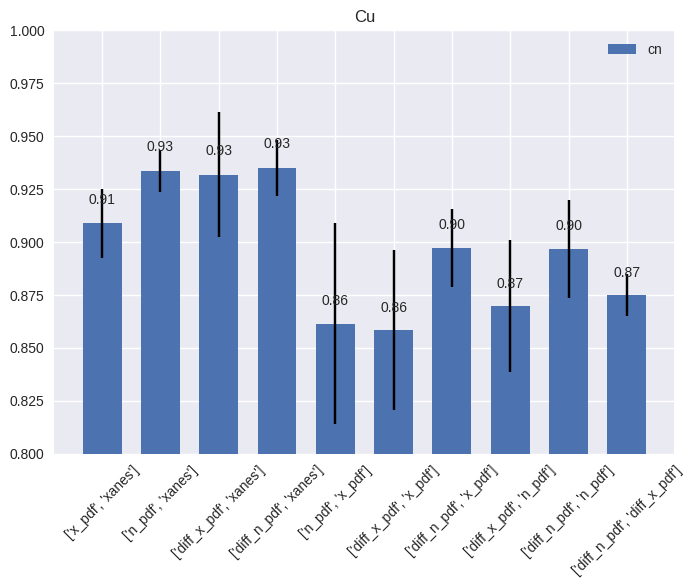

In [431]:
ele_condition = lambda x: x['element'] == 'Cu'
target_condition = cn_condition
leg = 'cn'
xtick_labels = features_of_interest
means = []
stds = []
painter = Painter()

for i in range(len(feature_conditions)):
    data = data_filter(Data, [*feature_conditions[i], cn_condition, ele_condition])
    mean = combine_data(data, 'test_score', np.mean)[0]
    std = combine_data(data, 'test_score', np.std)[0]
    means.append(mean)
    stds.append(std)

painter.plot(xtick_labels, means, plot_param={'yerr':stds, 'label':'cn'})
plt.ylim([0.8,1])
plt.title('Cu')

# Mn

Text(0.5, 1.0, 'Mn')

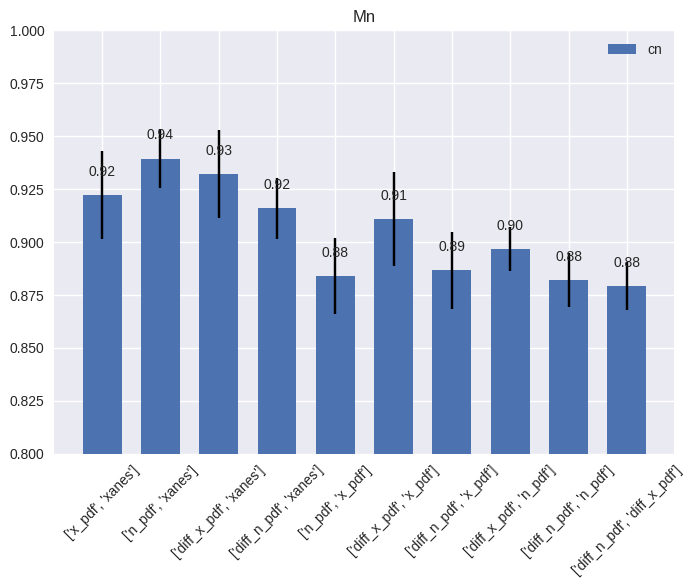

In [432]:
ele_condition = lambda x: x['element'] == 'Mn'
target_condition = cn_condition
leg = 'cn'
xtick_labels = features_of_interest
means = []
stds = []
painter = Painter()

for i in range(len(feature_conditions)):
    data = data_filter(Data, [*feature_conditions[i], cn_condition, ele_condition])
    mean = combine_data(data, 'test_score', np.mean)[0]
    std = combine_data(data, 'test_score', np.std)[0]
    means.append(mean)
    stds.append(std)

painter.plot(xtick_labels, means, plot_param={'yerr':stds, 'label':'cn'})
plt.ylim([0.8,1])
plt.title('Mn')

# Fe

Text(0.5, 1.0, 'Fe')

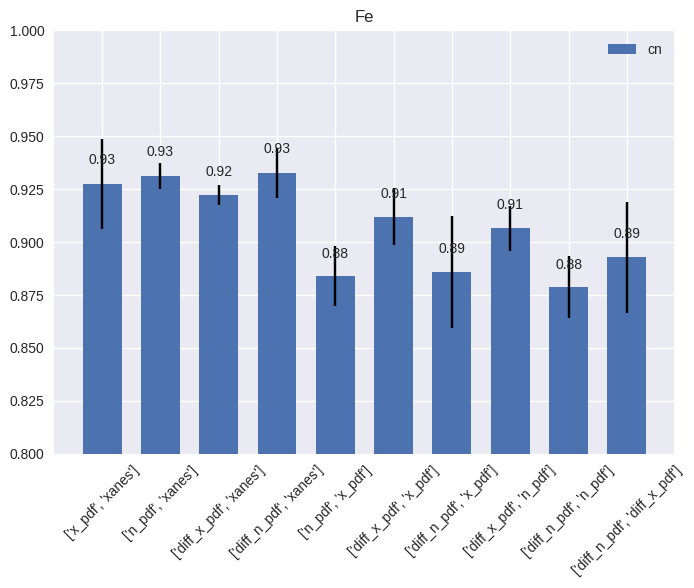

In [434]:
ele_condition = lambda x: x['element'] == 'Fe'
target_condition = cn_condition
leg = 'cn'
xtick_labels = features_of_interest
means = []
stds = []
painter = Painter()

for i in range(len(feature_conditions)):
    data = data_filter(Data, [*feature_conditions[i], cn_condition, ele_condition])
    mean = combine_data(data, 'test_score', np.mean)[0]
    std = combine_data(data, 'test_score', np.std)[0]
    means.append(mean)
    stds.append(std)

painter.plot(xtick_labels, means, plot_param={'yerr':stds, 'label':'cn'})
plt.ylim([0.8,1])
plt.title('Fe')